# Popularity analysis of Linux distributions

## Contents
1. [Scraping Data](#scraping-data)
1. [Loading Data](#loading-data)
1. [Most Popular Distros](#most-popular-distros)
1. [Linear Regression](#linear-regression)
1. [Geographical Data](#geo)
1. [Correlation Between Desktop Environment and Popularity](#correlation-between-desktop-environment-and-popularity)
1. [Principal Component Analysis](#principal-component-analysis)
1. [K-Means Clustering](#k-means-clustering)
1. [ARIMA](#arima)
1. [SARIMAX](#sarimax)
1. [Random Forest Regression](#random-forest-regression)

## Scraping Data

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import pandas as pd
from datetime import date
import os

def run_scraper():
    data_path = './data/'

    # Get current date in ISO format
    current_date = date.today().isoformat()

    # Set up headless browser
    options = Options()
    options.headless = True  # Run Chrome in headless mode (no GUI)
    options.add_argument('--headless')  # Ensure it's in headless mode
    options.add_argument('--disable-gpu')  # Disable GPU hardware acceleration
    options.add_argument('--no-sandbox')  # Disable the sandbox (helpful for Windows)
    options.add_argument('--disable-dev-shm-usage')  # Use /tmp for shared memory
    driver = webdriver.Chrome(options=options)

    # Open the URL
    url = "https://distrowatch.com/dwres.php?resource=popularity"
    driver.get(url)

    # Wait for the page to load (you may need to adjust this for your use case)
    driver.implicitly_wait(5)

    # Get page source after JavaScript is rendered
    html = driver.page_source

    # Parse the page source with BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    title = soup.title.string if soup.title else 'No title'
    print(f'Title of the page: {title}')

    # Create a set to store unique names
    unique_names = set()
    distro_names_file = data_path + 'distro_names.csv'

    # Check if the CSV file exists
    if os.path.exists(distro_names_file):
        # If it exists, read the CSV into a DataFrame
        distro_names = pd.read_csv(distro_names_file, index_col=0)
    else:
        # If it does not exist, create a new DataFrame with the specified columns
        distro_names = pd.DataFrame(columns=['full_name', 'short_name'])

    # Find all <td> elements with class 'phr2'
    td_elements_phr2 = soup.find_all('td', class_='phr2')

    # Check if we found any <td> with class 'phr2'
    if td_elements_phr2:
        # Iterate through all <td> elements with class 'phr2'
        for td_element in td_elements_phr2:
            # Find all <a> tags within the current <td> element
            links = td_element.find_all('a')
            for link in links:
                unique_names.add(link['href'])
                #print(f"Link text: {link.get_text()}, URL: {link['href']}")
                distro_names.loc[len(distro_names)] = [link.get_text(), link['href']]
    else:
        print("No <td> elements with class 'phr2' found.")

    print(unique_names)
    distro_names.drop_duplicates().to_csv(distro_names_file)


    column_names = ['Distro', 'OS Type', 'Based On', 'Origin', 'Architecture', 'Desktop', 
                    'Category', 'Status', 'Popularity']

    df = pd.DataFrame(columns=column_names)

    # Function to visit each link and perform actions (like scraping)
    def visit_links(links):
        for link in links:
            try:
                print(f"Visiting: {link}")
                driver.get(link)  # Navigate to the link
                # Wait for page to load completely
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
                
                page_title = driver.title
                print(f"Page title: {page_title}")
                
                html = driver.page_source

                # Parse the HTML
                soup = BeautifulSoup(html, 'html.parser')

                li_elements = soup.select('body > table > tbody > tr > td > table > tbody > tr > td > ul > li')
    
                extracted_data = [li.text.split(":")[1].strip() if ":" in li.text else li.text for li in li_elements]

                final_data = extracted_data[:8]
                distro_name = link.split("=")[1] 
                final_data.insert(0, distro_name)

                print(final_data)
                df.loc[len(df)] = final_data

                time.sleep(15)

            except Exception as e:
                print(f"Error visiting {link}: {e}")

        df.to_csv("distros_" + current_date + ".csv")


    def getURL(name):
        return "https://cumulative.com/table.php?distribution=" + name


    def generateURLs():
        urls = list()
        for un in unique_names:
            urls.append(getURL(un))
        return urls


    # Visit all the links
    visit_links(generateURLs())

    # Close the browser
    driver.quit()

In [2]:
# Uncomment the line below to run the scraper
#run_scraper()

## Loading data

In [3]:
data_path = './data/'
cumulative_data_path = data_path + 'cumulative/'

file_list = ['cumulative_2024-12-11.csv',
             'cumulative_2024-12-12.csv',
             'cumulative_2024-12-13.csv',
             'cumulative_2024-12-14.csv',
             'cumulative_2024-12-15.csv',
             'cumulative_2024-12-16.csv',
             'cumulative_2024-12-17.csv',
             'cumulative_2024-12-18.csv',
             'cumulative_2024-12-19.csv',
             'cumulative_2024-12-20.csv',
             'cumulative_2024-12-21.csv',
             'cumulative_2024-12-22.csv',
             'cumulative_2024-12-23.csv',
             'cumulative_2024-12-24.csv',
             'cumulative_2024-12-25.csv',
             'cumulative_2024-12-26.csv',
             'cumulative_2024-12-27.csv',
             'cumulative_2024-12-28.csv',
             'cumulative_2024-12-29.csv',
             'cumulative_2024-12-30.csv',
             'cumulative_2024-12-31.csv',
             'cumulative_2025-01-01.csv',
             'cumulative_2025-01-02.csv',
             'cumulative_2025-01-03.csv',
             'cumulative_2025-01-04.csv',
             'cumulative_2025-01-05.csv',
             'cumulative_2025-01-06.csv',
             'cumulative_2025-01-07.csv',
             'cumulative_2025-01-08.csv']

dfs = list()

columns = [
    'rank_12m', 'distro_12m', 'hpd_12m',
    'rank_6m', 'distro_6m', 'hpd_6m',
    'rank_3m', 'distro_3m', 'hpd_3m',
    'rank_1m', 'distro_1m', 'hpd_1m'
]

for file in file_list:
    df = pd.read_csv(cumulative_data_path + file, skiprows=0, dtype={'rank_12m': int, 'distro_12m': str, 'hpd_12m': int, 'rank_6m': int, 'distro_6m': str, 'hpd_6m': int, 'rank_3m': int, 'distro_3m': str, 'hpd_3m': int, 'rank_1m': int, 'distro_1m': str, 'hpd_1m': int})

    # Set the column names in the existing DataFrame
    df.columns = columns

    # Create a new DataFrame with the desired structure
    reshaped_df = pd.DataFrame({
        'distro_name': df['distro_12m'], # Take the distro name from the 12m column
        'rank_12m': df['rank_12m'],
        'hpd_12m': df['hpd_12m'],
        'rank_6m': df['rank_6m'],
        'hpd_6m': df['hpd_6m'],
        'rank_3m': df['rank_3m'],
        'hpd_3m': df['hpd_3m'],
        'rank_1m': df['rank_1m'],
        'hpd_1m': df['hpd_1m'],
    })

    dfs.append(reshaped_df)

In [4]:
# Load data containing details about each distro
df_distros = pd.read_csv(data_path + 'distros_2024-12-21.csv', index_col=0)

## Most Popular Distros

Text(0, 0.5, 'hits per day')

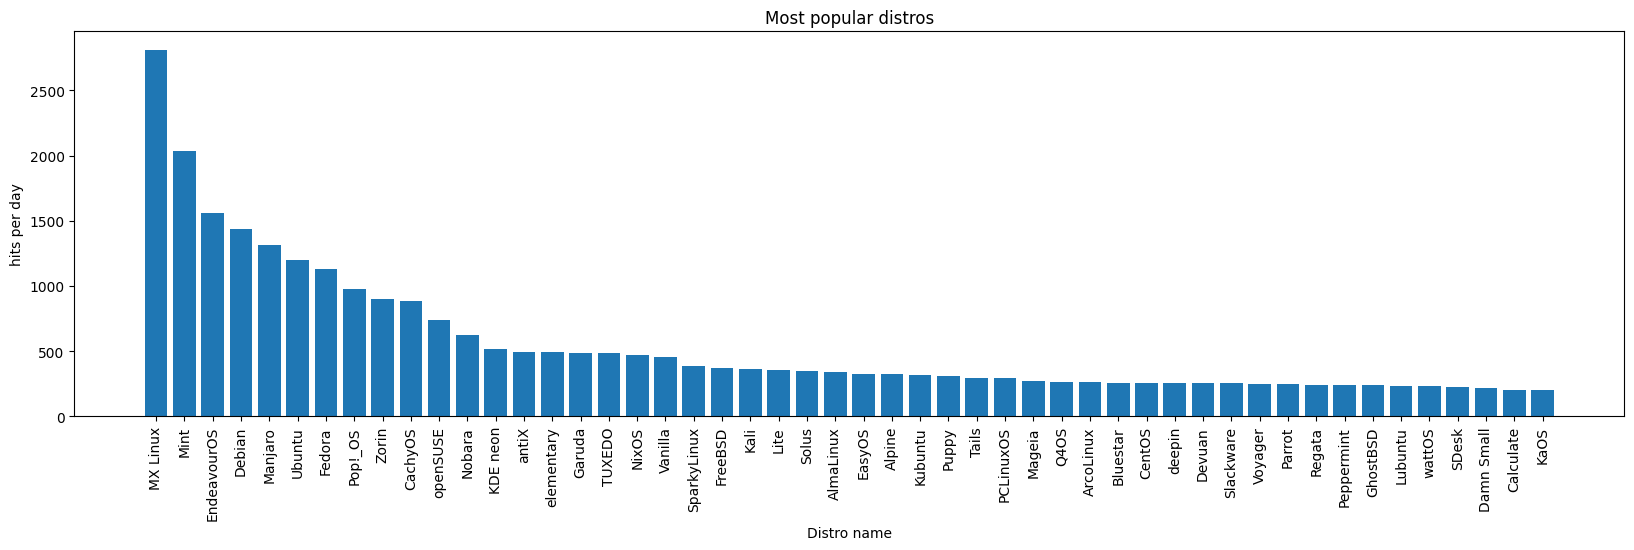

In [5]:
import matplotlib.pyplot as plt

df_subset = dfs[0].head(50)  # Get the first 50 rows
plt.figure(figsize=(20, 5))
plt.bar(df_subset['distro_name'], df_subset['hpd_1m'])
plt.xticks(rotation=90)
plt.title('Most popular distros')
plt.xlabel('Distro name')
plt.ylabel('hits per day')

## Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression
from datetime import date, timedelta, datetime

first_date = datetime(2024, 12, 11)


def regression(distro, future_date):
    data_to_fit = pd.DataFrame(columns=['date', 'hpd'])
    for i, df in enumerate(dfs):
        row = df[df['distro_name'] == distro]
        data_to_fit.loc[len(data_to_fit)] = [first_date + timedelta(days=i), row['hpd_1m'].iloc[0]]

    # Calculate the variance of the 'hpd' values
    variance_hpd = data_to_fit['hpd'].var()  # Variance of HPD
    print(f"Variance of HPD: {variance_hpd}")

    # Initial data
    plt.scatter(data_to_fit['date'], data_to_fit['hpd'])
    plt.title(distro)
    plt.xticks(rotation=90)
    plt.xlabel('date')
    plt.ylabel('hits per day')

    # Convert date to numeric format
    data_to_fit['date'] = pd.to_datetime(data_to_fit['date'], errors='coerce')  
    data_to_fit['date_numeric'] = (data_to_fit['date'] - data_to_fit['date'].min()).dt.days
    
    # Fit the model to data
    model = LinearRegression()
    model.fit(data_to_fit[['date_numeric']], data_to_fit['hpd'])
    predictions = model.predict(data_to_fit[['date_numeric']])
    plt.plot(data_to_fit['date'], predictions, label='Linear Regression', color='red', linestyle='--')

    # Convert future date to numeric format
    future_date = pd.to_datetime(future_date, errors='coerce')  
    future_date_numeric = (future_date - data_to_fit['date'].min()).days 
    df_future_date = pd.DataFrame({
    'date_numeric': [future_date_numeric]  # Add the numeric date as a column
    })

    # Predicting hpd for a future date
    future_hpd = model.predict(df_future_date)

    # Plot the future prediction as a red dot
    plt.scatter(future_date, future_hpd, color='green', label=f'Prediction for {future_date.strftime("%Y-%m-%d")}')
    print('Prediction for ' + future_date.isoformat() + ' is: ' + str(future_hpd[0]))

Variance of HPD: 2137.0911330049257
Prediction for 2025-01-09T00:00:00 is: 1299.9950738916257


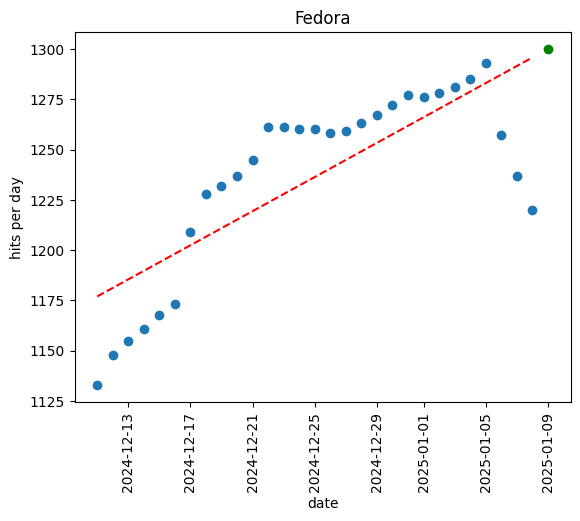

In [7]:
regression('Fedora', date(2025, 1, 9))

Variance of HPD: 425.256157635468
Prediction for 2025-01-09T00:00:00 is: 787.2733990147783


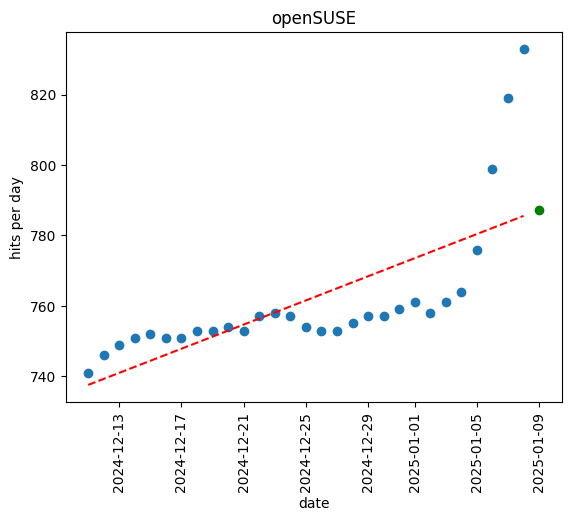

In [8]:
regression('openSUSE', date(2025, 1, 9))

Variance of HPD: 66.65024630541872
Prediction for 2025-01-09T00:00:00 is: 207.6576354679803


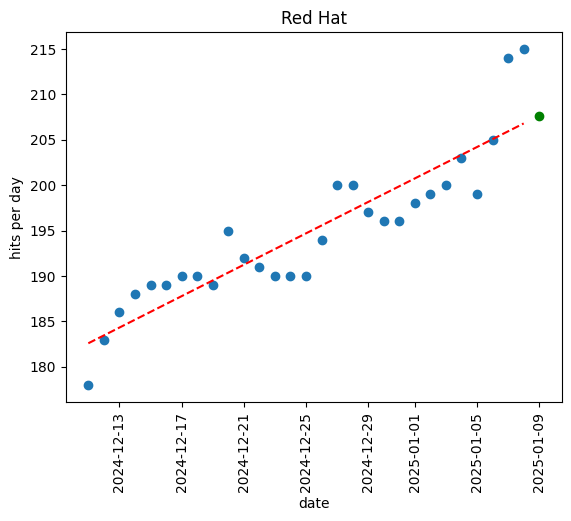

In [9]:
regression('Red Hat', date(2025, 1, 9))

## Geographical Data

In [10]:
country_counts = df_distros['Origin'].value_counts()
# Convert the series into a DataFrame
country_counts_df = country_counts.reset_index()

# Rename the columns for better readability
country_counts_df.columns = ['Origin', 'Count']

# Rename 'USA' to 'United States of America' so it can be merged with natural earth data and shown on map
usa_count = country_counts_df.loc[country_counts_df['Origin'] == 'USA']['Count']
country_counts_df.loc[country_counts_df['Origin'] == 'USA'] = ['United States of America', usa_count[0]]

print(country_counts_df.head(25))

                      Origin  Count
0   United States of America     64
1                     France     21
2                    Germany     17
3                     Global     16
4                      Italy     13
5             United Kingdom     12
6                      Spain     10
7                     Canada     10
8                Switzerland      7
9                    Ireland      6
10                    Poland      6
11                     Japan      6
12                    Russia      6
13               Netherlands      6
14                     India      5
15                     China      5
16                 Australia      5
17                    Brazil      5
18               Isle of Man      4
19                   Austria      3
20                    Turkey      3
21                    Norway      3
22            Czech Republic      2
23                    Sweden      2
24                    Taiwan      2


In [11]:
# Function to extract number before first space
def extract_number(text):
    space_pos = text.find(' ')
    return int(text[:space_pos] if space_pos != -1 else text)  # Handle case where no space is found

# Apply the function to the column
df_distros['numerical_popularity'] = df_distros['Popularity'].apply(extract_number)

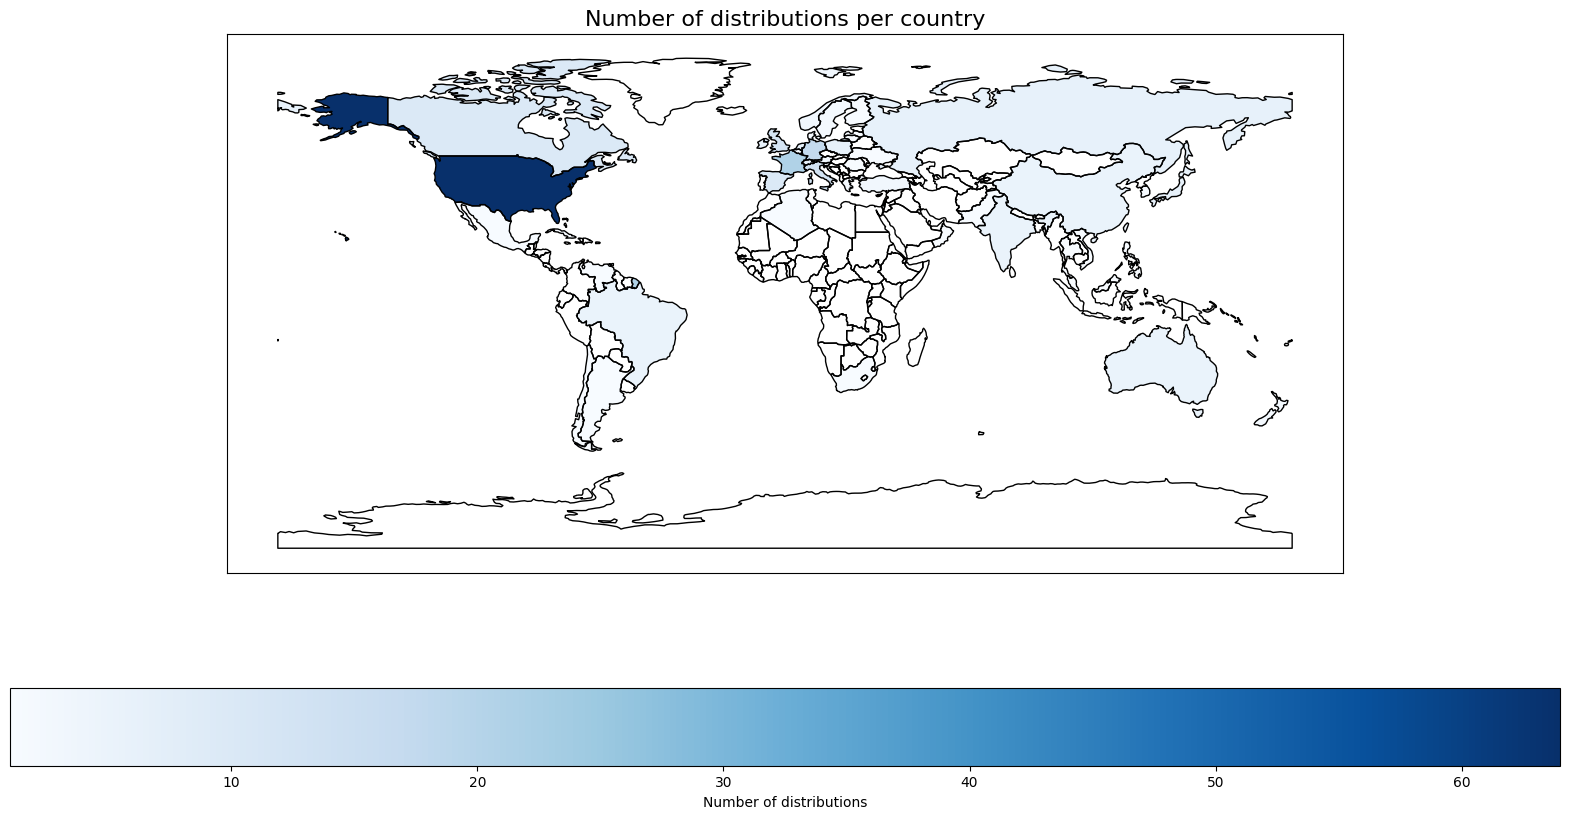

In [12]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Load the low resolution world map
world = gpd.read_file('./ne/ne_110m_admin_0_countries.shp')

world = world.merge(country_counts_df, left_on='ADMIN', right_on='Origin', how='left')

# Initialize an empty figure and add an axis
fig, ax = plt.subplots(figsize=(20, 10))

world.boundary.plot(ax=ax, linewidth=1, color='black')  # Add country boundaries

# Plot the countries with a colormap based on GDP
world.plot(
    ax=ax,
    column='Count',
    cmap='Blues',
    legend=True,
    legend_kwds={'label': "Number of distributions", 'orientation': "horizontal"},
    alpha=1
)

# Turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Set the plot title
plt.title("Number of distributions per country", fontsize=16)
plt.show()


## Correlation between desktop environment and popularity

In [13]:
# Split 'Desktop' column by commas and expand the DataFrame to multiple rows
df_split = df_distros.set_index(['Distro', 'numerical_popularity'])['Desktop'].str.split(', ', expand=True).stack().reset_index(name='Desktop')

# Now each distro has a separate row for each desktop environment
df_split = df_split[['Distro', 'Desktop', 'numerical_popularity']]

print(df_split)

           Distro        Desktop  numerical_popularity
0       eurolinux          GNOME                   111
1       eurolinux     KDE Plasma                   111
2           zorin          GNOME                    11
3           zorin           Xfce                    11
4     ufficiozero       Cinnamon                   118
..            ...            ...                   ...
701  postmarketos          Phosh                   144
702  postmarketos  Plasma Mobile                   144
703  postmarketos           Sxmo                   144
704       ferenos       Cinnamon                   169
705       ferenos     KDE Plasma                   169

[706 rows x 3 columns]


In [14]:
from sklearn.preprocessing import LabelEncoder

# Label encode the 'Desktop' column
label_encoder = LabelEncoder()
df_split['Desktop_encoded'] = label_encoder.fit_transform(df_split['Desktop'])

# Now calculate the correlation
correlation = df_split['Desktop_encoded'].corr(df_split['numerical_popularity'])
print(f"Correlation between Desktop Environment and Popularity: {correlation}")


Correlation between Desktop Environment and Popularity: 0.07422045382633032


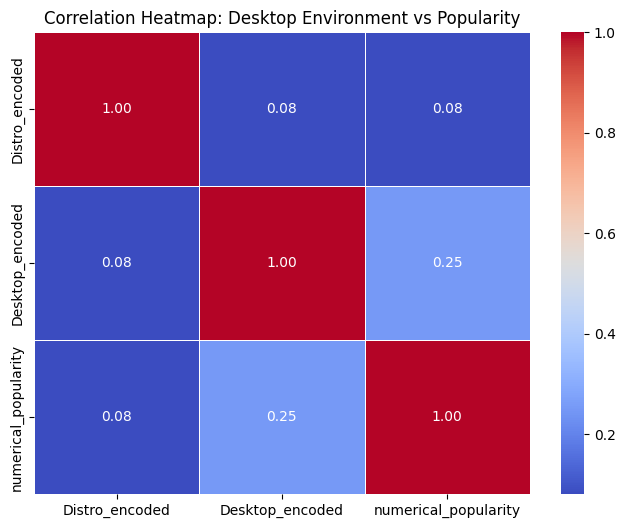

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


# Encode the 'Distro' and 'Desktop' columns
distro_encoder = LabelEncoder()
desktop_encoder = LabelEncoder()

df_distros['Distro_encoded'] = distro_encoder.fit_transform(df_distros['Distro'])
df_distros['Desktop_encoded'] = desktop_encoder.fit_transform(df_distros['Desktop'])


correlation_matrix = df_distros[['Distro_encoded', 'Desktop_encoded', 'numerical_popularity']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Desktop Environment vs Popularity')
plt.show()


Visualization of how the popularity of distros relates to desktop environments

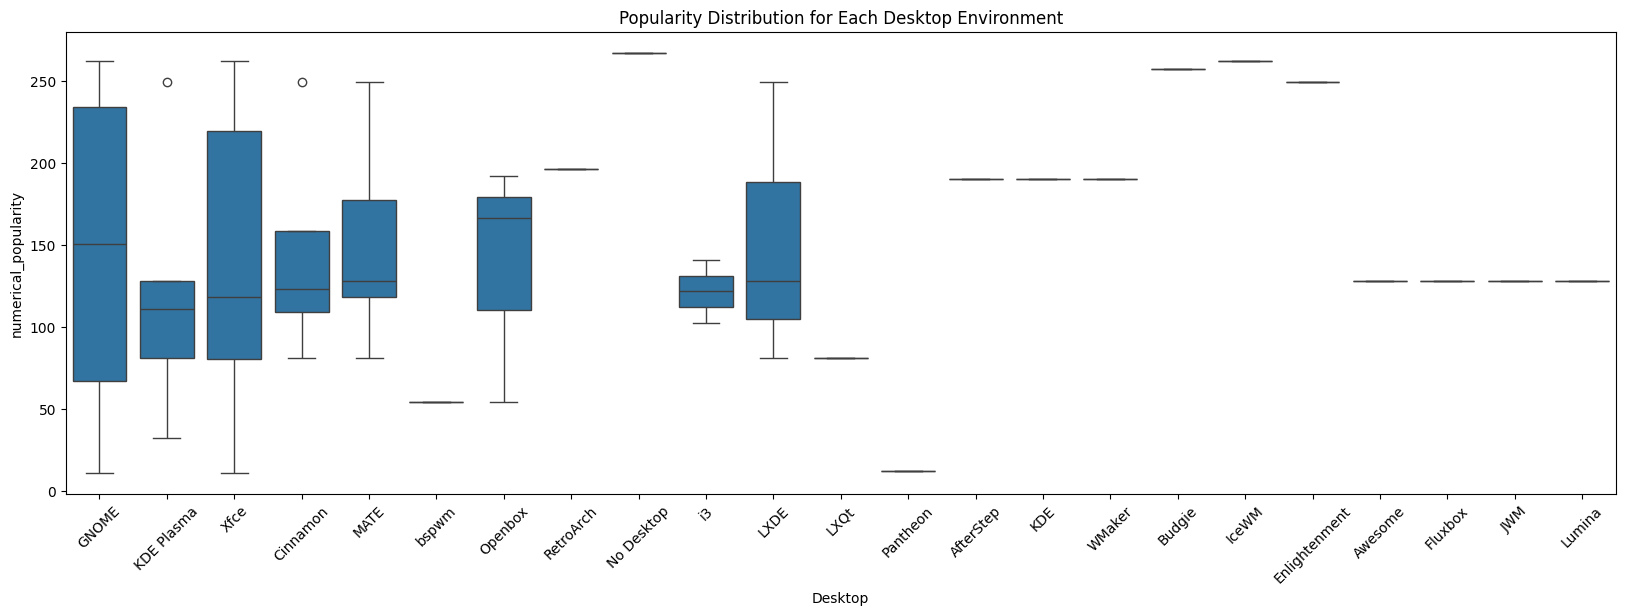

In [16]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Desktop', y='numerical_popularity', data=df_split.head(50))
plt.title('Popularity Distribution for Each Desktop Environment')
plt.xticks(rotation=45)
plt.show()

## Principal Component Analysis

Explained Variance Ratio: [0.15621597 0.04952653]


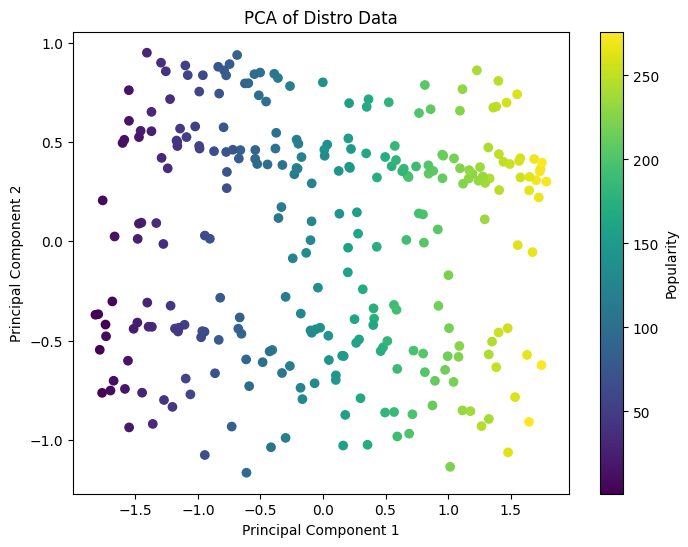

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# We'll first define which columns are categorical and numerical
categorical_columns = ['Distro', 'OS Type', 'Based On', 'Origin', 'Architecture', 'Desktop', 'Category', 'Status']
numerical_columns = ['numerical_popularity']

# Define a column transformer
# OneHotEncoding for categorical columns and StandardScaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
         ('num', StandardScaler(), numerical_columns),  # Scale numerical columns
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Create a pipeline with preprocessor and PCA
pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))  # Reduce to 2 components for visualization
])

# Fit and transform the data using the pipeline
X_pca = pca_pipeline.fit_transform(df_distros)

# Explained Variance Ratio
print("Explained Variance Ratio:", pca_pipeline.named_steps['pca'].explained_variance_ratio_)

# Scatter plot for the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_distros['numerical_popularity'], cmap='viridis')
plt.colorbar(label='Popularity')
plt.title("PCA of Distro Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


## Hierarchical Clustering

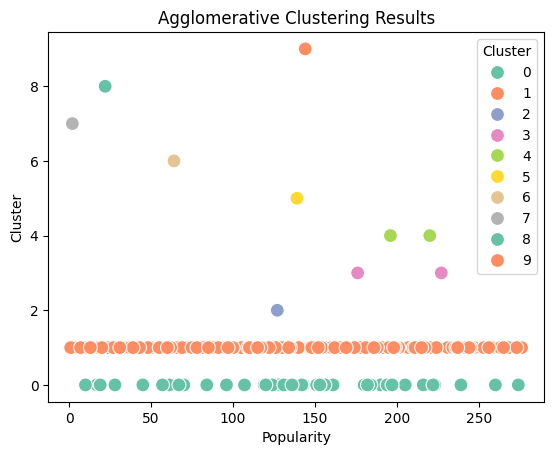

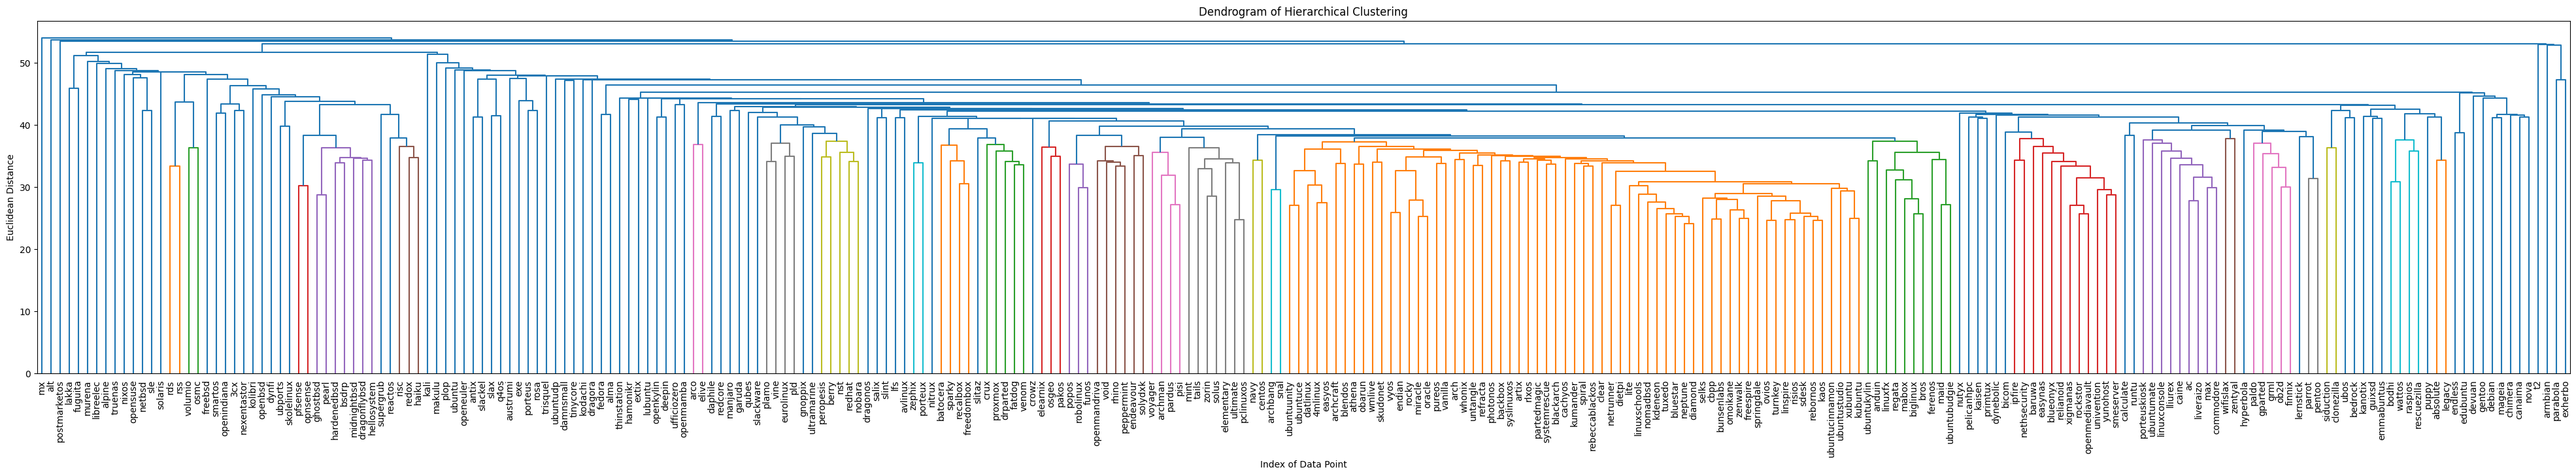

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

df = df_distros

# Preprocess the data (Standardize the numerical features)
df_encoded = pd.get_dummies(df.drop(columns=['Popularity']))  # One-hot encoding categorical data
X = pd.concat([df_encoded, df['numerical_popularity']], axis=1)  # Adding the numerical feature

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform Agglomerative Hierarchical Clustering
model = AgglomerativeClustering(n_clusters=10)
df['Cluster'] = model.fit_predict(X_scaled)

# Visualize the results
sns.scatterplot(x=df['numerical_popularity'], y=df['Cluster'], hue=df['Cluster'], palette='Set2', s=100)
plt.title("Agglomerative Clustering Results")
plt.xlabel('Popularity')
plt.ylabel('Cluster')
plt.show()

# Generate the Dendrogram for visualization
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(50, 7))
dendrogram(linked, labels=df['Distro'].values, orientation='top', leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of Hierarchical Clustering")
plt.xlabel("Index of Data Point")
plt.ylabel("Euclidean Distance")
plt.show()

## ARIMA

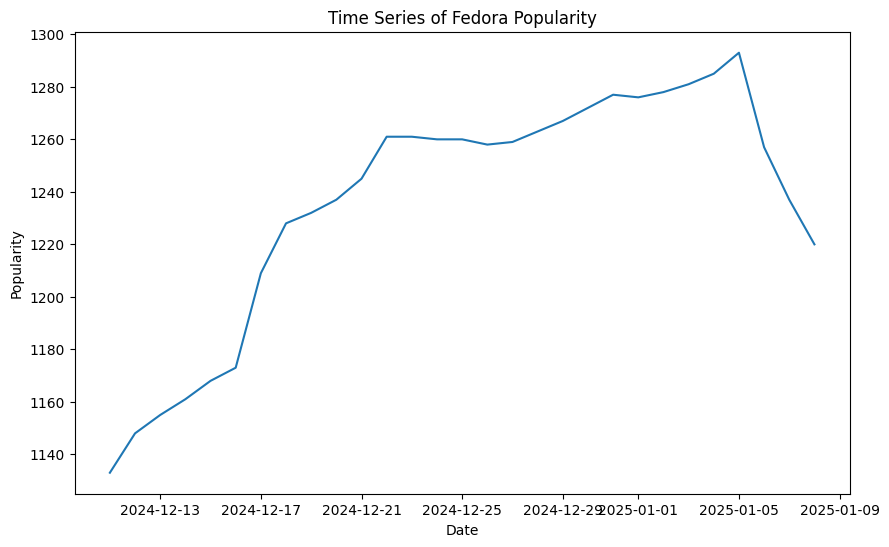

2025-01-09    1213.686875
2025-01-10    1212.462934
2025-01-11    1200.490623
2025-01-12    1188.971382
2025-01-13    1178.321006
2025-01-14    1171.507995
2025-01-15    1167.759115
2025-01-16    1162.150992
2025-01-17    1155.974652
2025-01-18    1149.792565
Freq: D, Name: predicted_mean, dtype: float64


In [19]:
from statsmodels.tsa.arima.model import ARIMA

first_date = datetime(2024, 12, 11)

distro_name = 'Fedora'
arima_data = pd.DataFrame(columns=['date', 'hpd'])
for i, df in enumerate(dfs):
    row = df[df['distro_name'] == distro_name]
    arima_data.loc[len(arima_data)] = [first_date + timedelta(days=i), row['hpd_1m'].iloc[0]]

# Set the date column as the index
arima_data.set_index('date', inplace=True)

# Explicitly set the frequency to daily (D) for the datetime index
arima_data.index = pd.DatetimeIndex(arima_data.index, freq='D')

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(arima_data)
plt.title(f'Time Series of {distro_name} Popularity')
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

# Fit an ARIMA model
arima_model = ARIMA(arima_data, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Forecast future values
arima_forecast = arima_model_fit.forecast(steps=10)
print(arima_forecast)

## SARIMAX

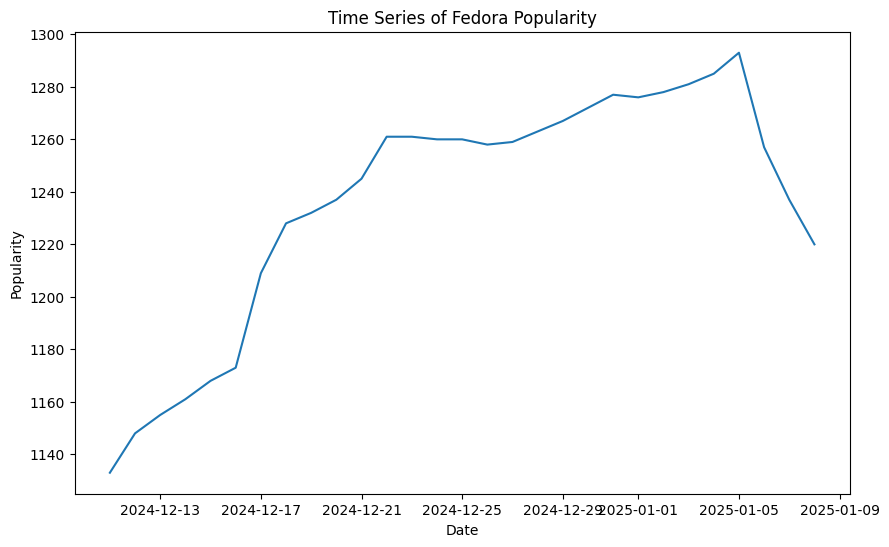

ADF Statistic: -1.9528294875733283
p-value: 0.30763071798171027


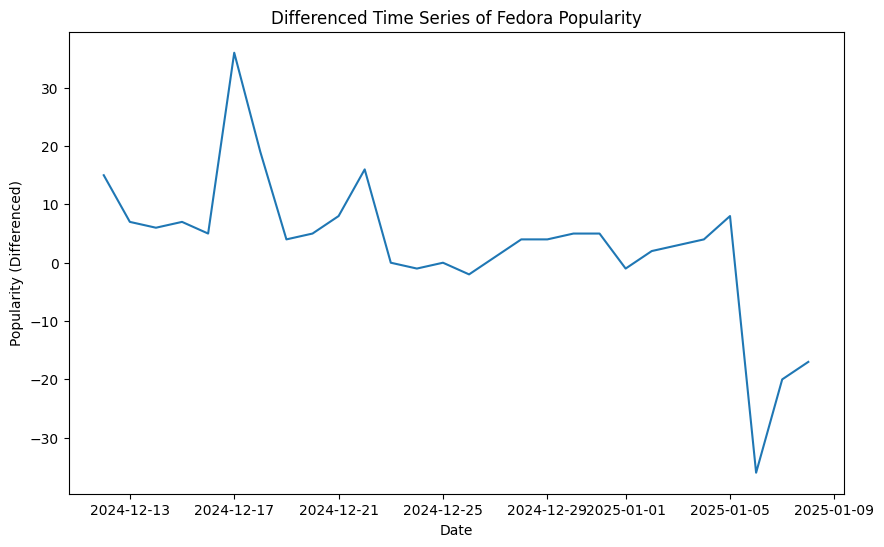

C:\Users\Amadeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                                hpd   No. Observations:                   29
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   3.974
Date:                            Thu, 09 Jan 2025   AIC                              2.052
Time:                                    00:07:11   BIC                             -4.482
Sample:                                12-11-2024   HQIC                           -11.613
                                     - 01-08-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0139   1.08e-05   9.36e+04      0.000       1.014       1.014
ma.L1         -1.9404   1.86e-06  -

C:\Users\Amadeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
C:\Users\Amadeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


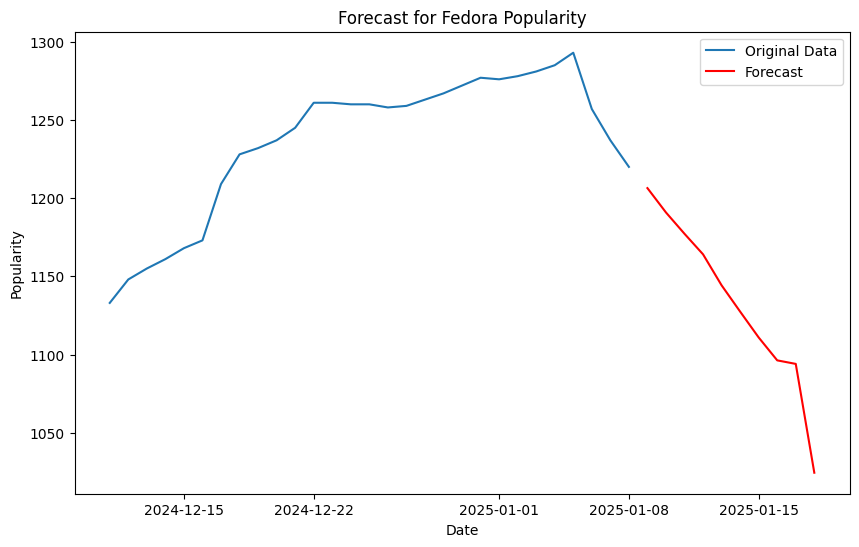

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller  # To check stationarity

first_date = datetime(2024, 12, 11)
distro_name = 'Fedora'

# Create an empty DataFrame to store the data for time series analysis
sarimax_data = pd.DataFrame(columns=['date', 'hpd'])

# Loop through each DataFrame in dfs to extract 'hpd_1m' for the given distro
for i, df in enumerate(dfs):
    row = df[df['distro_name'] == distro_name]
    # Add a new row with date and the 'hpd_1m' value for the selected distro
    sarimax_data.loc[len(sarimax_data)] = [first_date + timedelta(days=i), row['hpd_1m'].iloc[0]]

# Convert the 'date' column to datetime
sarimax_data['date'] = pd.to_datetime(sarimax_data['date'])

# Set the 'date' column as the index of the DataFrame
sarimax_data.set_index('date', inplace=True)

# Explicitly set the frequency to daily (D) for the datetime index
sarimax_data.index = pd.DatetimeIndex(sarimax_data.index, freq='D')

# Now, 'sarimax_data' should have the correct date index and 'hpd' values.
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(sarimax_data['hpd'])
plt.title(f'Time Series of {distro_name} Popularity')
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.show()

# Check for stationarity using the Augmented Dickey-Fuller test
adf_result = adfuller(sarimax_data['hpd'].dropna())  # Drop NA values for the test
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If p-value > 0.05, the series is non-stationary, and we need differencing

# Apply differencing if necessary (d=1 for first difference)
sarimax_data['hpd_diff'] = sarimax_data['hpd'].diff().dropna()

# Replot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(sarimax_data['hpd_diff'])
plt.title(f'Differenced Time Series of {distro_name} Popularity')
plt.xlabel('Date')
plt.ylabel('Popularity (Differenced)')
plt.show()

# SARIMA Model fitting
# We choose (p, d, q) and (P, D, Q) parameters. Here we use (1, 1, 1) for simplicity
# and set the seasonal period `s=12` for monthly data with yearly seasonality.
sarimax_model = SARIMAX(sarimax_data['hpd'], 
                order=(1, 1, 1),  # Non-seasonal order (p, d, q)
                seasonal_order=(1, 1, 1, 12),  # Seasonal order (P, D, Q, s)
                enforce_stationarity=False,  # Don't enforce stationarity constraints
                enforce_invertibility=False)  # Don't enforce invertibility constraints

# Fit the model
sarimax_model_fit = sarimax_model.fit(disp=False)

# Print the summary of the fitted model
print(sarimax_model_fit.summary())

# Forecast future values (e.g., next 10 days)
sarimax_forecast = sarimax_model_fit.forecast(steps=10)
print(f"Forecast for {distro_name}:")
print(sarimax_forecast)

# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(sarimax_data['hpd'], label='Original Data')
plt.plot(pd.date_range(start=sarimax_data.index[-1], periods=11, freq='D')[1:], sarimax_forecast, label='Forecast', color='red')
plt.title(f"Forecast for {distro_name} Popularity")
plt.xlabel('Date')
plt.ylabel('Popularity')
plt.legend()
plt.show()


## K-means Clustering

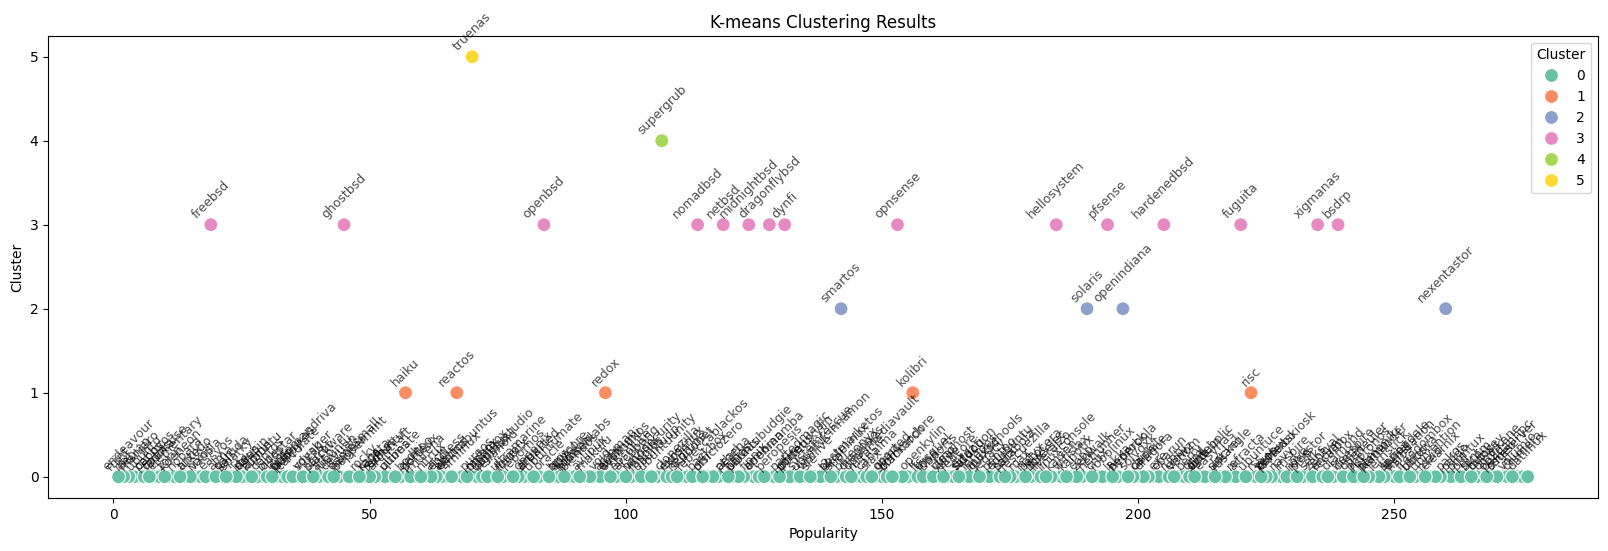

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Preprocess the data
df = df_distros
df_encoded = pd.get_dummies(df['OS Type'])  # One-hot encoding categorical data
#X = pd.concat([df_encoded, df['numerical_popularity']], axis=1)  # Adding the numerical feature
X = df_encoded

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(20, 6))
sns.scatterplot(x=df['numerical_popularity'], y=df['Cluster'], hue=df['Cluster'], palette='Set2', s=100)

# Add OS names to the plot
for i in range(len(df)):
    plt.annotate(df['Distro'].iloc[i], (df['numerical_popularity'].iloc[i], df['Cluster'].iloc[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, alpha=0.7, rotation=45)

plt.title('K-means Clustering Results')
plt.xlabel('Popularity')
plt.ylabel('Cluster')
plt.show()

## Random Forest Regression

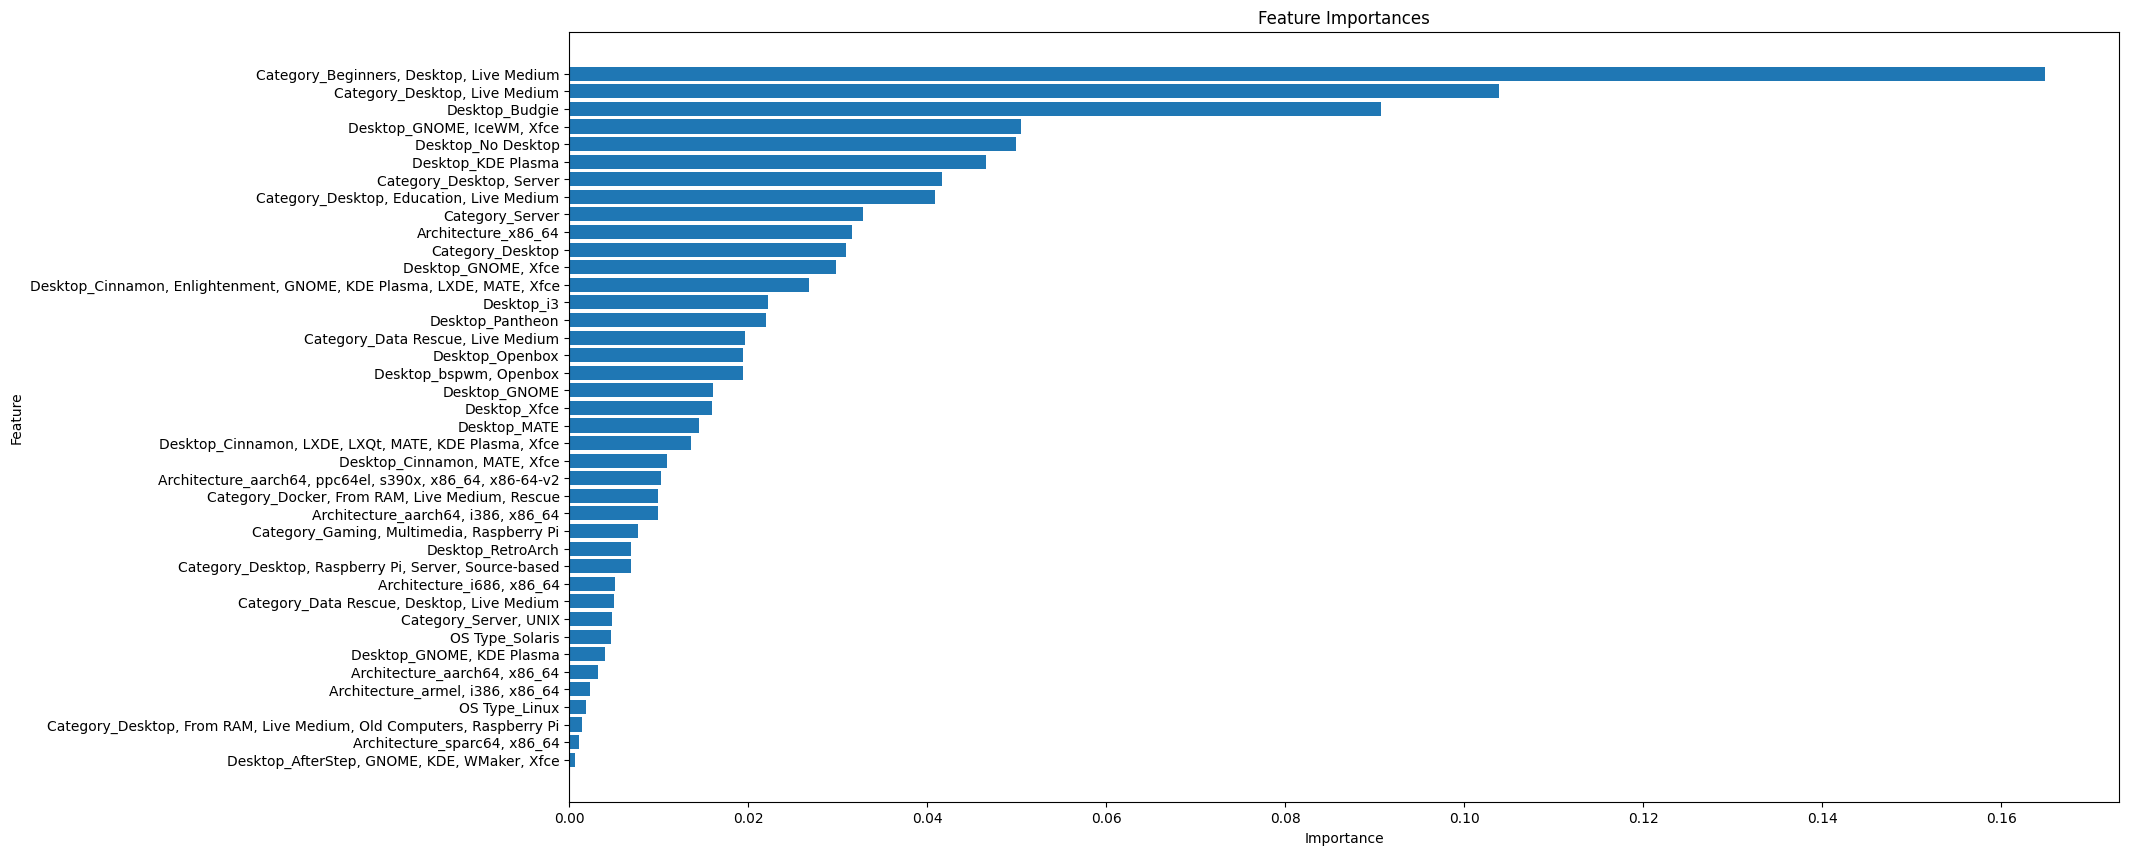

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numerical columns
#categorical_columns = ['Distro', 'OS Type', 'Based On', 'Origin', 'Architecture', 'Desktop', 'Category', 'Status']
categorical_columns = ['OS Type', 'Architecture', 'Desktop', 'Category']
#numerical_columns = ['numerical_popularity']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        #('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Create the pipeline with preprocessor and RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
X = df_distros.head(20)
y = df_distros.head(20)['numerical_popularity']
pipeline.fit(X, y)

# Get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
#feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns).tolist() + numerical_columns
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_columns).tolist()

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()